In [ ]:
!pip install -U transformers==4.46.2 accelerate==1.2.1 datasets evaluate seqeval sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 107.4 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=3b7d482748d7f04b5cf4608c3f5bb22de238ee5d2b85a9400eb89f58a6bbe895
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval
  Attempting uninstall: pyarrow
    F

In [ ]:
!pip uninstall -y peft

Found existing installation: peft 0.18.0
Uninstalling peft-0.18.0:
  Successfully uninstalled peft-0.18.0


In [ ]:
# CELL 0 — RUN ONCE
# Preprocessing + tokenizer + shared functions + splits

import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer
)
import evaluate
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -------------- CONFIG --------------
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 0.01
GRADIENT_ACCUMULATION = 2
WARMUP_STEPS = 500
FP16 = True  # use mixed precision if available

# -------------- LOAD CSV --------------
# Update path if needed
df = pd.read_csv("/content/TV_Reviews(Sheet1).csv")
assert {"sentence_id", "word", "tag"}.issubset(df.columns), "CSV must have sentence_id, word, tag"

# -------------- GROUP SENTENCES --------------
sentences = []
tags = []
for _, g in df.groupby("sentence_id"):
    sentences.append(g["word"].tolist())
    tags.append(g["tag"].tolist())

print(f"Total sentences: {len(sentences)}")

# -------------- LABELS --------------
# You said 3 classes — build label list from data to map
label_list = sorted(list({t for seq in tags for t in seq}))
if len(label_list) != 3:
    print("Warning: found", len(label_list), "unique labels in data. Expected 3.")
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for l, i in label2id.items()}
num_labels = len(label_list)
print("Labels:", label_list)

# Convert tags -> ids
label_ids = [[label2id[t] for t in seq] for seq in tags]

# -------------- HF Dataset --------------
hf_ds = Dataset.from_dict({"tokens": sentences, "labels": label_ids})

# -------------- TOKENIZER --------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, add_prefix_space=True)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )
    aligned_labels = []
    for i, lab in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        prev_word_idx = None
        label_ids_per_token = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids_per_token.append(-100)
            elif word_idx != prev_word_idx:
                # first token of the word
                label_ids_per_token.append(lab[word_idx])
            else:
                # continuation token
                label_ids_per_token.append(-100)
            prev_word_idx = word_idx
        aligned_labels.append(label_ids_per_token)
    tokenized_inputs["labels"] = aligned_labels
    return tokenized_inputs

# -------------- METRICS helpers --------------
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=2)

    true_preds = [
        [label_list[p] for (p, l) in zip(pred_seq, lab_seq) if l != -100]
        for pred_seq, lab_seq in zip(preds, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(pred_seq, lab_seq) if l != -100]
        for pred_seq, lab_seq in zip(preds, labels)
    ]

    results = seqeval.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# -------------- K-Fold splits (random) --------------
kf = KFold(n_splits=6, shuffle=True, random_state=None)
splits = list(kf.split(hf_ds))   # store splits so all cells use same fold indices within this session
print("Prepared 6 random folds (shuffle=True).")


Total sentences: 12044
Labels: ['BOC', 'IOC', 'O']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Prepared 6 random folds (shuffle=True).


Map:   0%|          | 0/10036 [00:00<?, ? examples/s]

Map:   0%|          | 0/2008 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-258494361.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 1 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.731400,0.550404,0.248459,0.252896,0.250658,0.774506
2,0.524900,0.496210,0.336962,0.343629,0.340263,0.800039
3,0.442700,0.488143,0.350799,0.381274,0.365402,0.804809
4,0.373900,0.493016,0.366177,0.373069,0.369591,0.811769
5,0.321800,0.516567,0.355870,0.375965,0.365642,0.807664


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 1)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.25836181640625, 'eval_precision': 0.5222495739443287, 'eval_recall': 0.5266373878174527, 'eval_f1': 0.5244343030994486, 'eval_accuracy': 0.8991709868225729, 'eval_runtime': 23.3424, 'eval_samples_per_second': 429.947, 'eval_steps_per_second': 26.904, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.516567051410675, 'eval_precision': 0.35587026039287345, 'eval_recall': 0.37596525096525096, 'eval_f1': 0.36564186810607835, 'eval_accuracy': 0.807663734115347, 'eval_runtime': 4.788, 'eval_samples_per_second': 419.381, 'eval_steps_per_second': 26.316, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.75      0.66      0.70      8829
         IOC       0.84      0.83      0.84     31905
           O       0.93      0.95      0.94     90627

    accuracy                           0.90    131361
   macro avg       0.84      0.81      0.8

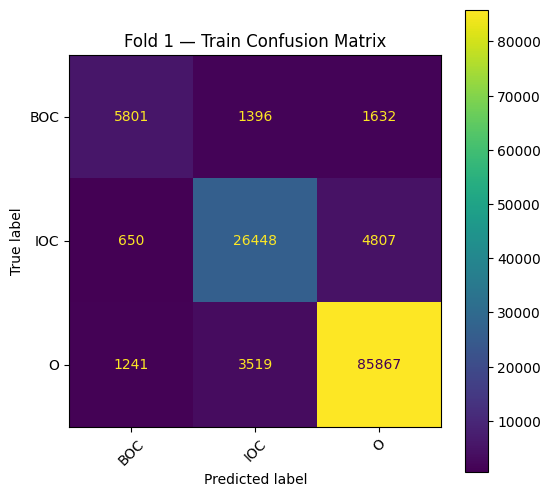

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.60      0.51      0.55      1777
         IOC       0.70      0.67      0.68      6385
           O       0.86      0.89      0.88     17413

    accuracy                           0.81     25575
   macro avg       0.72      0.69      0.70     25575
weighted avg       0.80      0.81      0.80     25575



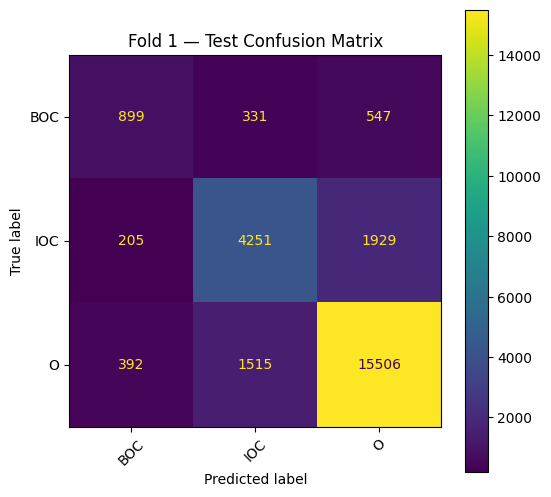

In [ ]:
# CELL 1 — FOLD 1
fold_idx = 1
train_idx, test_idx = splits[0]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(tokenize_and_align_labels, batched=True, remove_columns=train_data.column_names)
tokenized_test  = test_data.map(tokenize_and_align_labels, batched=True, remove_columns=test_data.column_names)

# create model and move to GPU
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    evaluation_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

# Evaluate (trainer.evaluate uses compute_metrics)
print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# ---------------- Predictions & Confusion Matrices ----------------
def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

# Train confusion matrix
y_true_train, y_pred_train = preds_and_labels(tokenized_train)
cm_labels = label_list  # sorted label strings
cm_train = confusion_matrix(y_true_train, y_pred_train, labels=cm_labels, normalize=None)
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

# Test confusion matrix
y_true_test, y_pred_test = preds_and_labels(tokenized_test)
cm_test = confusion_matrix(y_true_test, y_pred_test, labels=cm_labels, normalize=None)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Map:   0%|          | 0/10036 [00:00<?, ? examples/s]

Map:   0%|          | 0/2008 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-3962749016.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 2 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.721600,0.555956,0.244577,0.278316,0.260358,0.767759
2,0.527200,0.484230,0.321411,0.317522,0.319455,0.802892
3,0.442700,0.469108,0.351638,0.368829,0.360028,0.809526
4,0.374100,0.476417,0.356667,0.362536,0.359578,0.813884
5,0.323100,0.490065,0.345938,0.358664,0.352186,0.810181


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 2)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.26020413637161255, 'eval_precision': 0.5262058488416255, 'eval_recall': 0.5288167938931297, 'eval_f1': 0.5275080906148866, 'eval_accuracy': 0.8981955024960688, 'eval_runtime': 23.3549, 'eval_samples_per_second': 429.718, 'eval_steps_per_second': 26.889, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.49006491899490356, 'eval_precision': 0.34593837535014005, 'eval_recall': 0.3586640851887706, 'eval_f1': 0.3521863117870722, 'eval_accuracy': 0.8101812572310065, 'eval_runtime': 4.4373, 'eval_samples_per_second': 452.526, 'eval_steps_per_second': 28.396, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.76      0.65      0.70      8840
         IOC       0.84      0.83      0.83     31997
           O       0.93      0.95      0.94     90169

    accuracy                           0.90    131006
   macro avg       0.84      0.81    

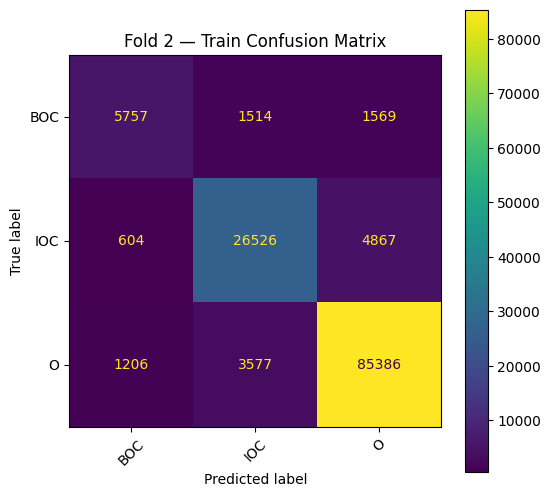

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.60      0.49      0.54      1766
         IOC       0.69      0.67      0.68      6293
           O       0.87      0.89      0.88     17871

    accuracy                           0.81     25930
   macro avg       0.72      0.69      0.70     25930
weighted avg       0.81      0.81      0.81     25930



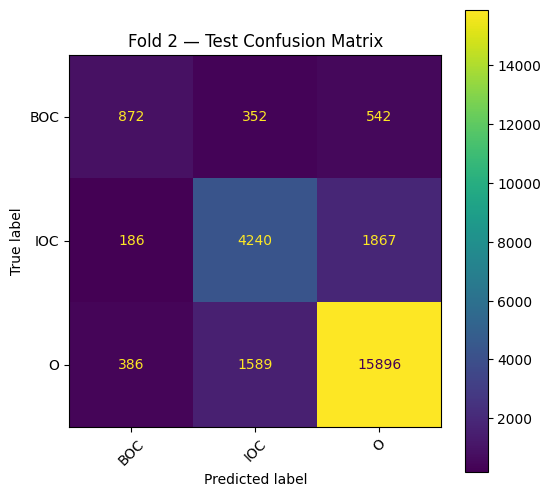

In [ ]:
# CELL 2 — FOLD 2
fold_idx = 2
train_idx, test_idx = splits[1]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(tokenize_and_align_labels, batched=True, remove_columns=train_data.column_names)
tokenized_test  = test_data.map(tokenize_and_align_labels, batched=True, remove_columns=test_data.column_names)

model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    evaluation_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# Confusion matrices
def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

y_true_train, y_pred_train = preds_and_labels(tokenized_train)
cm_labels = label_list
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_train, y_pred_train, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_test, y_pred_test, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Map:   0%|          | 0/10037 [00:00<?, ? examples/s]

Map:   0%|          | 0/2007 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-4291839201.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 3 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.722300,0.565597,0.216282,0.251531,0.232578,0.760721
2,0.524600,0.485618,0.313084,0.315591,0.314333,0.802039
3,0.439100,0.472174,0.350836,0.355629,0.353216,0.806049
4,0.367800,0.486201,0.341932,0.343382,0.342656,0.808187
5,0.320800,0.497427,0.350942,0.359868,0.355349,0.811510


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 3)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.25762930512428284, 'eval_precision': 0.5414728682170543, 'eval_recall': 0.536122037801017, 'eval_f1': 0.5387841681531119, 'eval_accuracy': 0.8988061094157508, 'eval_runtime': 23.3173, 'eval_samples_per_second': 430.452, 'eval_steps_per_second': 26.933, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.49742692708969116, 'eval_precision': 0.35094166283876893, 'eval_recall': 0.35986811116344797, 'eval_f1': 0.3553488372093023, 'eval_accuracy': 0.8115095276282125, 'eval_runtime': 4.4404, 'eval_samples_per_second': 451.983, 'eval_steps_per_second': 28.376, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.76      0.66      0.71      8839
         IOC       0.84      0.83      0.84     31732
           O       0.93      0.95      0.94     90178

    accuracy                           0.90    130749
   macro avg       0.84      0.81    

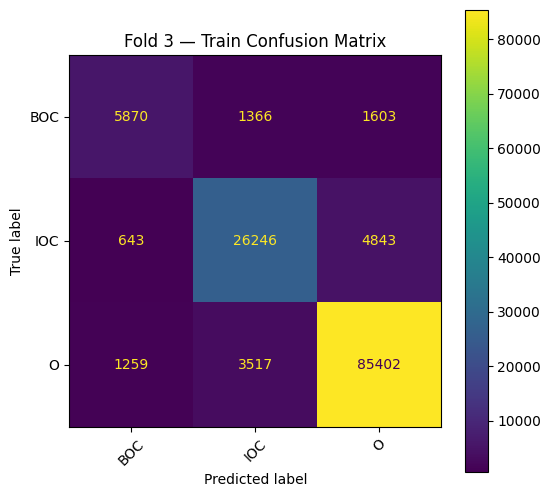

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.58      0.49      0.53      1767
         IOC       0.71      0.67      0.69      6558
           O       0.87      0.89      0.88     17862

    accuracy                           0.81     26187
   macro avg       0.72      0.69      0.70     26187
weighted avg       0.81      0.81      0.81     26187



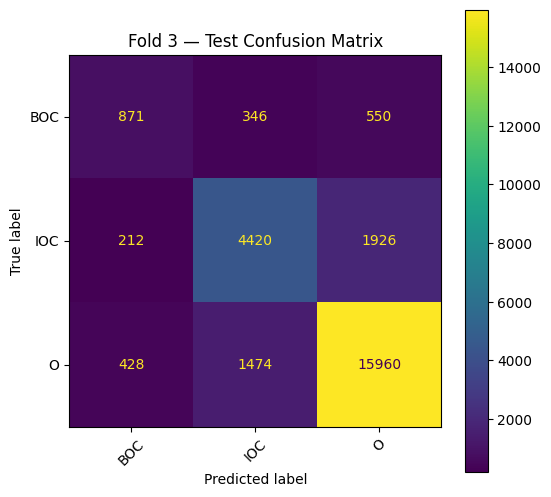

In [ ]:
# CELL 3 — FOLD 3
fold_idx = 3
train_idx, test_idx = splits[2]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(tokenize_and_align_labels, batched=True, remove_columns=train_data.column_names)
tokenized_test  = test_data.map(tokenize_and_align_labels, batched=True, remove_columns=test_data.column_names)

model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    evaluation_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# Confusion matrices same as above
def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

y_true_train, y_pred_train = preds_and_labels(tokenized_train)
cm_labels = label_list
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_train, y_pred_train, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_test, y_pred_test, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Map:   0%|          | 0/10037 [00:00<?, ? examples/s]

Map:   0%|          | 0/2007 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-2070851630.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 4 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.723200,0.560348,0.258780,0.264525,0.261621,0.768875
2,0.524200,0.482777,0.336240,0.327822,0.331978,0.803779
3,0.437300,0.465193,0.350113,0.364667,0.357242,0.809204
4,0.369100,0.477112,0.364668,0.379310,0.371845,0.813605
5,0.319500,0.491090,0.376242,0.375531,0.375887,0.818613


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 4)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.25750914216041565, 'eval_precision': 0.5262050497322112, 'eval_recall': 0.5275673602454694, 'eval_f1': 0.5268853243954991, 'eval_accuracy': 0.8981681447104413, 'eval_runtime': 23.2917, 'eval_samples_per_second': 430.925, 'eval_steps_per_second': 26.962, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.49108973145484924, 'eval_precision': 0.3762423095125414, 'eval_recall': 0.3755314123760038, 'eval_f1': 0.3758865248226951, 'eval_accuracy': 0.8186129448364823, 'eval_runtime': 4.4378, 'eval_samples_per_second': 452.25, 'eval_steps_per_second': 28.392, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.75      0.66      0.70      8831
         IOC       0.84      0.83      0.84     32047
           O       0.93      0.95      0.94     89700

    accuracy                           0.90    130578
   macro avg       0.84      0.81      

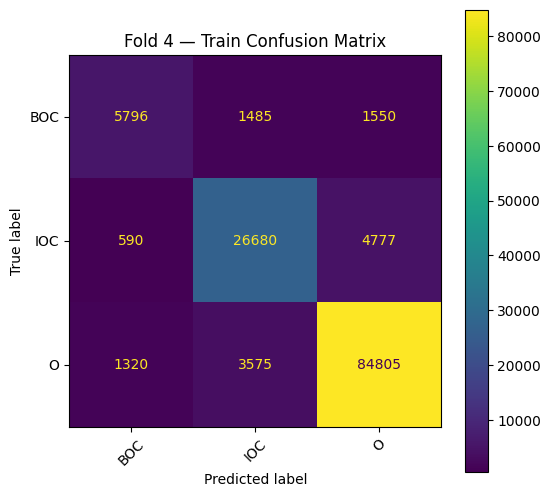

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.62      0.51      0.56      1775
         IOC       0.70      0.67      0.68      6243
           O       0.87      0.90      0.89     18340

    accuracy                           0.82     26358
   macro avg       0.73      0.69      0.71     26358
weighted avg       0.81      0.82      0.82     26358



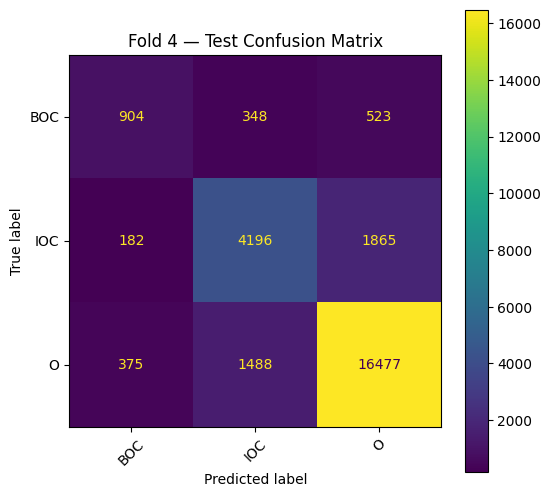

In [ ]:
# CELL 4 — FOLD 4
fold_idx = 4
train_idx, test_idx = splits[3]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(tokenize_and_align_labels, batched=True, remove_columns=train_data.column_names)
tokenized_test  = test_data.map(tokenize_and_align_labels, batched=True, remove_columns=test_data.column_names)

model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    evaluation_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# Confusion matrices
def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

y_true_train, y_pred_train = preds_and_labels(tokenized_train)
cm_labels = label_list
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_train, y_pred_train, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_test, y_pred_test, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Map:   0%|          | 0/10037 [00:00<?, ? examples/s]

Map:   0%|          | 0/2007 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-2644665740.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 5 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.722100,0.552467,0.247120,0.224976,0.235529,0.771176
2,0.530400,0.477883,0.335143,0.323642,0.329292,0.805156
3,0.443500,0.455003,0.367248,0.361296,0.364248,0.821441
4,0.375400,0.449624,0.372235,0.377026,0.374615,0.823538
5,0.324500,0.474390,0.375231,0.387035,0.381042,0.823310


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 5)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.2606144845485687, 'eval_precision': 0.5264067601305934, 'eval_recall': 0.5246937212863706, 'eval_f1': 0.5255488447895695, 'eval_accuracy': 0.8975787017557281, 'eval_runtime': 23.3564, 'eval_samples_per_second': 429.732, 'eval_steps_per_second': 26.888, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.4743902087211609, 'eval_precision': 0.3752310536044362, 'eval_recall': 0.38703527168732127, 'eval_f1': 0.38104176442984516, 'eval_accuracy': 0.823309561038862, 'eval_runtime': 4.4899, 'eval_samples_per_second': 447.0, 'eval_steps_per_second': 28.063, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.76      0.65      0.70      8815
         IOC       0.84      0.82      0.83     31818
           O       0.93      0.95      0.94     90082

    accuracy                           0.90    130715
   macro avg       0.84      0.81      0.

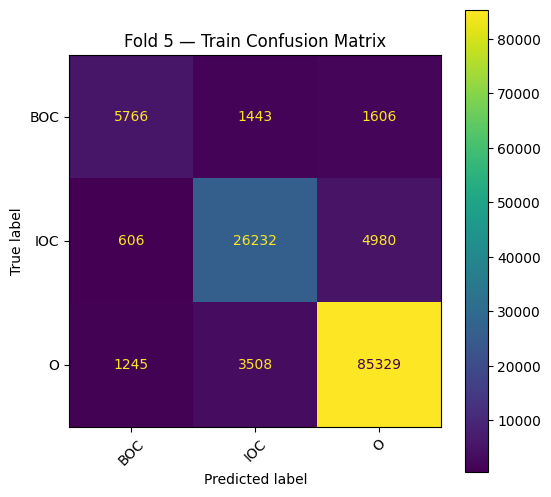

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.62      0.51      0.56      1791
         IOC       0.72      0.69      0.70      6472
           O       0.87      0.90      0.89     17958

    accuracy                           0.82     26221
   macro avg       0.74      0.70      0.72     26221
weighted avg       0.82      0.82      0.82     26221



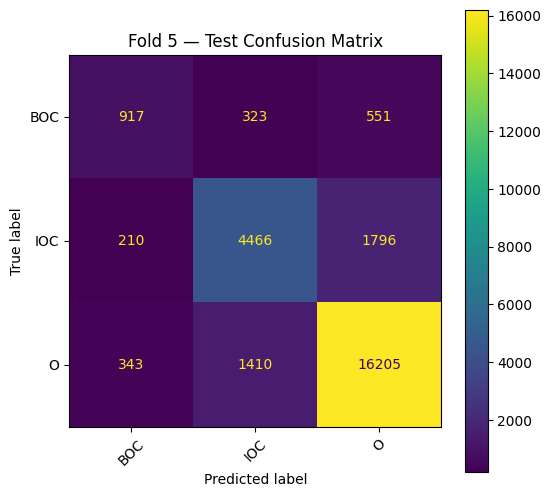

In [ ]:
# CELL 5 — FOLD 5
fold_idx = 5
train_idx, test_idx = splits[4]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(tokenize_and_align_labels, batched=True, remove_columns=train_data.column_names)
tokenized_test  = test_data.map(tokenize_and_align_labels, batched=True, remove_columns=test_data.column_names)

model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    evaluation_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# Confusion matrices
def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

y_true_train, y_pred_train = preds_and_labels(tokenized_train)
cm_labels = label_list
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_train, y_pred_train, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_test, y_pred_test, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Map:   0%|          | 0/10037 [00:00<?, ? examples/s]

Map:   0%|          | 0/2007 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-4161717756.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 6 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.724000,0.558421,0.266949,0.213043,0.236969,0.772811
2,0.526800,0.487905,0.332441,0.300000,0.315389,0.801313
3,0.443900,0.463730,0.352582,0.362802,0.357619,0.813313
4,0.371000,0.475764,0.356939,0.362802,0.359847,0.814551
5,0.322200,0.489974,0.351613,0.368599,0.359906,0.814813


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 6)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.2594122588634491, 'eval_precision': 0.5371598884722623, 'eval_recall': 0.5333142420771286, 'eval_f1': 0.5352301575896921, 'eval_accuracy': 0.8979818992715186, 'eval_runtime': 23.3095, 'eval_samples_per_second': 430.598, 'eval_steps_per_second': 26.942, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.4899740517139435, 'eval_precision': 0.35161290322580646, 'eval_recall': 0.3685990338164251, 'eval_f1': 0.3599056603773585, 'eval_accuracy': 0.814813425839115, 'eval_runtime': 4.4632, 'eval_samples_per_second': 449.681, 'eval_steps_per_second': 28.231, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.75      0.66      0.71      8876
         IOC       0.85      0.82      0.83     31951
           O       0.93      0.95      0.94     89444

    accuracy                           0.90    130271
   macro avg       0.84      0.81      0

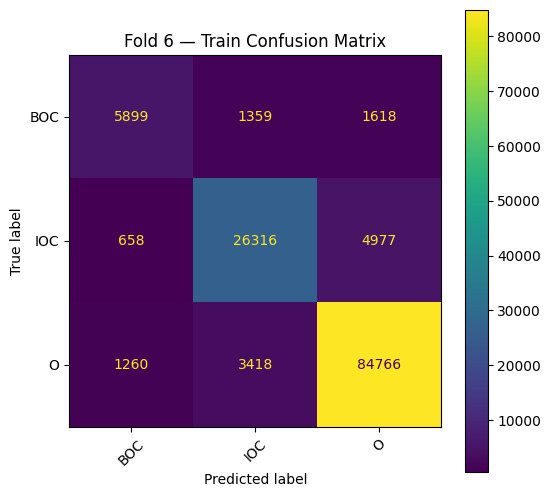

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.59      0.51      0.55      1730
         IOC       0.69      0.66      0.68      6339
           O       0.87      0.89      0.88     18596

    accuracy                           0.81     26665
   macro avg       0.72      0.69      0.70     26665
weighted avg       0.81      0.81      0.81     26665



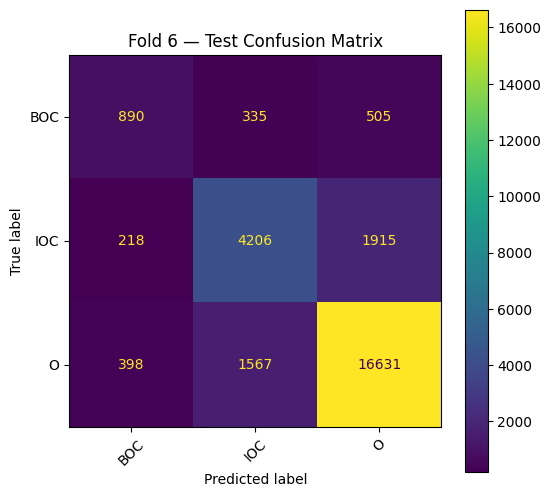

In [ ]:
# CELL 6 — FOLD 6
fold_idx = 6
train_idx, test_idx = splits[5]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(tokenize_and_align_labels, batched=True, remove_columns=train_data.column_names)
tokenized_test  = test_data.map(tokenize_and_align_labels, batched=True, remove_columns=test_data.column_names)

model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    evaluation_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# Confusion matrices
def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

y_true_train, y_pred_train = preds_and_labels(tokenized_train)
cm_labels = label_list
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_train, y_pred_train, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true_test, y_pred_test, labels=cm_labels), display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# -----------------------
# LOAD DATA PROPERLY
# -----------------------
df = pd.read_csv("/content/TV_Reviews_Cause_Sentiment(TV_Reviews_Cause_Sentiment).csv", encoding="latin1")

df = df[["Causal Phrase", "Sentiment"]].copy()
df["Sentiment"] = df["Sentiment"].astype(str).str.strip()
df = df[df["Sentiment"] != ""]

label2id = {"NEGATIVE": 0, "POSITIVE": 1}
id2label = {0: "NEGATIVE", 1: "POSITIVE"}

df = df[df["Sentiment"].isin(label2id.keys())]
df["label"] = df["Sentiment"].map(label2id)
df = df.dropna()

print("Cleaned dataset size:", len(df))

# -----------------------
# TRAIN / TEST SPLIT
# -----------------------
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

train_ds = Dataset.from_pandas(train_df[["Causal Phrase", "label"]])
test_ds  = Dataset.from_pandas(test_df[["Causal Phrase", "label"]])

# -----------------------
# TOKENIZER
# -----------------------
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["Causal Phrase"], truncation=True, padding="max_length", max_length=128)

train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

train_ds = train_ds.rename_column("label", "labels")
test_ds = test_ds.rename_column("label", "labels")

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# -----------------------
# MODEL
# -----------------------
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

# -----------------------
# METRICS
# -----------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    pm, rm, f1m, _ = precision_recall_fscore_support(labels, preds, average="macro")

    return {
        "accuracy": acc,
        "weighted_precision": p,
        "weighted_recall": r,
        "weighted_f1": f1,
        "macro_precision": pm,
        "macro_recall": rm,
        "macro_f1": f1m
    }

# -----------------------
# TRAINER
# -----------------------
training_args = TrainingArguments(
    output_dir="./sentiment_bert",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)

print("🚀 Training BERT-base-uncased sentiment classifier...")
trainer.train()

print("\n📊 Final Test Evaluation:")
print(trainer.evaluate(test_ds))


Cleaned dataset size: 6415
Train size: 5132 | Test size: 1283


Map:   0%|          | 0/5132 [00:00<?, ? examples/s]

Map:   0%|          | 0/1283 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3275472025.py:102: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.018914,0.995323,0.995438,0.995323,0.995346
2,0.049900,0.014489,0.997662,0.997667,0.997662,0.997664
3,0.049900,0.011996,0.997662,0.997667,0.997662,0.997664
4,0.007800,0.011580,0.997662,0.997667,0.997662,0.997664
5,0.000900,0.011636,0.997662,0.997667,0.997662,0.997664



FINAL METRICS: {'eval_loss': 0.011635874398052692, 'eval_accuracy': 0.9976617303195635, 'eval_precision': 0.997667450555174, 'eval_recall': 0.9976617303195635, 'eval_f1': 0.9976636002171926, 'eval_runtime': 9.673, 'eval_samples_per_second': 132.638, 'eval_steps_per_second': 8.374, 'epoch': 5.0}

Generating Confusion Matrix...

Confusion Matrix:
[[ 239    1]
 [   2 1041]]


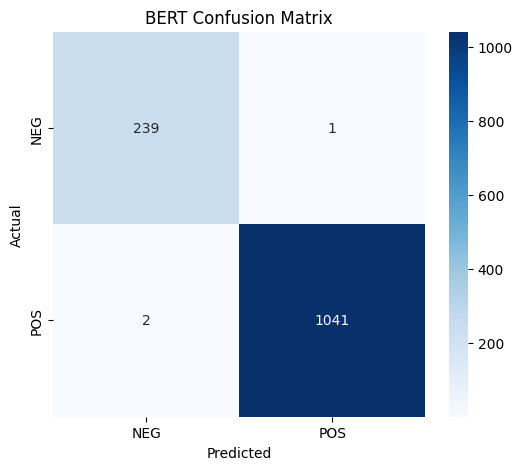

In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------
# LOAD DATA
# -----------------------
df = pd.read_csv("/content/TV_Reviews_Cause_Sentiment(TV_Reviews_Cause_Sentiment).csv", encoding="latin1")

df = df[["Causal Phrase", "Sentiment"]].copy()
df["Sentiment"] = df["Sentiment"].astype(str).str.strip()
df = df[df["Sentiment"] != ""]

label2id = {"NEGATIVE": 0, "POSITIVE": 1}
id2label = {0: "NEGATIVE", 1: "POSITIVE"}

df = df[df["Sentiment"].isin(label2id.keys())]
df["label"] = df["Sentiment"].map(label2id)
df = df.dropna()

print("Cleaned dataset size:", len(df))

# -----------------------
# TRAIN/TEST SPLIT
# -----------------------
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

print(f"Train size: {len(train_df)} | Test size: {len(test_df)}")

train_ds = Dataset.from_pandas(train_df[["Causal Phrase", "label"]])
test_ds  = Dataset.from_pandas(test_df[["Causal Phrase", "label"]])

# -----------------------
# TOKENIZER
# -----------------------
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["Causal Phrase"], truncation=True, padding="max_length", max_length=128)

train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

train_ds = train_ds.rename_column("label", "labels")
test_ds = test_ds.rename_column("label", "labels")

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# -----------------------
# MODEL
# -----------------------
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

# -----------------------
# METRICS
# -----------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

# -----------------------
# TRAINER
# -----------------------
training_args = TrainingArguments(
    output_dir="./sentiment_bert",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)

# -----------------------
# TRAIN
# -----------------------
trainer.train()

# -----------------------
# FINAL EVALUATION
# -----------------------
metrics = trainer.evaluate(test_ds)
print("\nFINAL METRICS:", metrics)

# -----------------------
# CONFUSION MATRIX
# -----------------------
print("\nGenerating Confusion Matrix...")
pred_output = trainer.predict(test_ds)

preds = np.argmax(pred_output.predictions, axis=1)
true_labels = pred_output.label_ids

cm = confusion_matrix(true_labels, preds)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["NEG", "POS"],
            yticklabels=["NEG", "POS"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("BERT Confusion Matrix")
plt.show()
